# True-peak detection

True-peak metering takes into account the idea of inter-sample peaks.
This means that the actual peak of the waveform is in between two adjacent samples, but it will not be possible to measure it until the signal is converted back to analog.
In the worst case, an inter-sample peak may lay outside the digital dynamic range [-1, 1], potentially generating clipping in further stages that cannot be noticed in the digital domain.

Although some sophisticated Digital to Analog Converters (DAC) can deal with inter-sample clipping, it is always better to detect it before reaching the DAC to make sure that this will not be a problem despite the conversion hardware.

There are several strategies to predict the inter-sample peaks. In this notebook, we focus on the approach based on oversampling the input signal.

## The ITU-R BS.1770 recommendation

The ITU-R BS.1770 recommendation proposes the following signal chain based on the oversampling strategy:

    -12.04dB --> x4 oversample --> LowPass --> abs() --> 20 * log10() --> +12.04dB

[TruePeakDetector](https://essentia.upf.edu/reference/std_TruePeakDetector.html) implements the true-peak level meter specified in the second annex of the ITU-R BS.1770-2[1] or the ITU-R BS.1770-4[2] (default).
In this implementation, the gain stages are suppressed as they are not required when working with float point values.
Also the result is returned in natural units.
Additionally, the algorithm returns the position of the samples outside the [-1, 1] range after resampling, as potential analog clipping candidates.

Here we show an example of true-peak metering:

In [ ]:
from essentia.standard import MonoLoader, TruePeakDetector
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (9, 5)

EPS = np.finfo(np.float32).eps

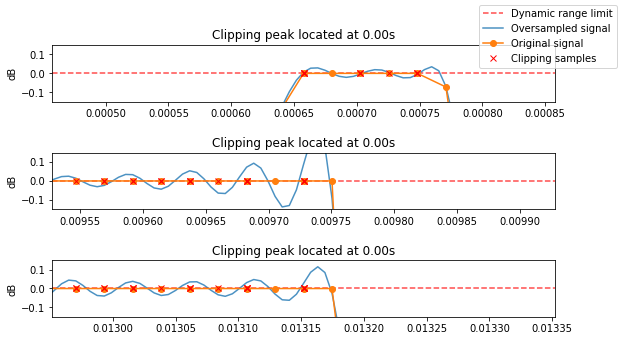

In [ ]:
sr = 44100

audio_file = "../../../test/audio/recorded/distorted.wav"
audio = MonoLoader(filename=audio_file)()

times = np.arange(len(audio)) / sr
oversampled_times = np.arange(len(audio) * 4) / (sr * 4)

peak_locations, output = TruePeakDetector(version=2)(audio)

n = 3  # Show three examples.
f, axes = plt.subplots(n)
f.subplots_adjust(hspace=0.9)
for idx in range(n):
    p_idx = idx * 100
    l0 = axes[idx].axhline(0, color="r", alpha=0.7, ls="--")
    l1 = axes[idx].plot(oversampled_times, 20 * np.log10(output + EPS), alpha=0.8)
    l2 = axes[idx].plot(times, 20 * np.log10(np.abs(audio + EPS)), marker="o")
    l3 = axes[idx].plot(peak_locations / sr, np.zeros(len(peak_locations)), color="r", marker="x", linestyle="None")

    axes[idx].set_xlim([peak_locations[p_idx] / sr - 0.0002, peak_locations[p_idx] / sr + 0.0002])
    axes[idx].set_ylim([-0.15, 0.15])
    axes[idx].set_title("Clipping peak located at {:.2f}s".format(peak_locations[p_idx] / (sr * 4)))
    axes[idx].set_ylabel("dB")

f.legend([l0, l1[-1], l2[-1], l3[-1]], ["Dynamic range limit (dB)", "Oversampled signal", "Original signal", "Clipped samples"])
plt.show()

The resampled signal is closer to the analog signal once it goes through the DAC. The part of this signal peaking above 1 may produce additional distortion if the analog amplifier doesn't have enough headroom to handle this additional amplitude. As this type of distortion depends entirely on the design of the playback hardware, it is always recommended to produce music so the true peak positions never overcome the dynamic range [-1, 1].

## References

[1] Series, B. S. (2011). Recommendation ITU-R BS.1770-2. Algorithms to measure audio programme loudness and true-peak audio level, https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-2-201103-S!!PDF-E.pdf

[2] Series, B. S. (2011). Recommendation ITU-R BS.1770-4. Algorithms to measure audio programme loudness and true-peak audio level, https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-4-201510-I!!PDF-E.pdf